# Magnetic and Gravity Data Integration and Clustering

In [1]:
# ### Ehsan Farahbakhsh and Hugo W. Fahey

# *EarthByte Group, School of Geosciences, University of Sydney, NSW 2006, Australia*

# This notebook enables the user to concatenate the geophysical features available for South Australia, reduce the dimensionality of 
# the feature space using the principal component analysis (PCA) method, and apply the k-means clustering method to the output components.

## Importing Libraries

In [2]:
import contextily as cx
import geopandas as gpd
from ipywidgets import interact
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
from osgeo import gdal, osr
import pandas as pd
import rioxarray as rxr
from scipy.interpolate import griddata
from shapely.geometry import mapping
from shapely.geometry import Point
from skimage import exposure, util
from skimage.feature import graycomatrix, graycoprops
from sklearn import cluster
from sklearn.decomposition import PCA
import sys
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

## Importing Layers

### Vector Files

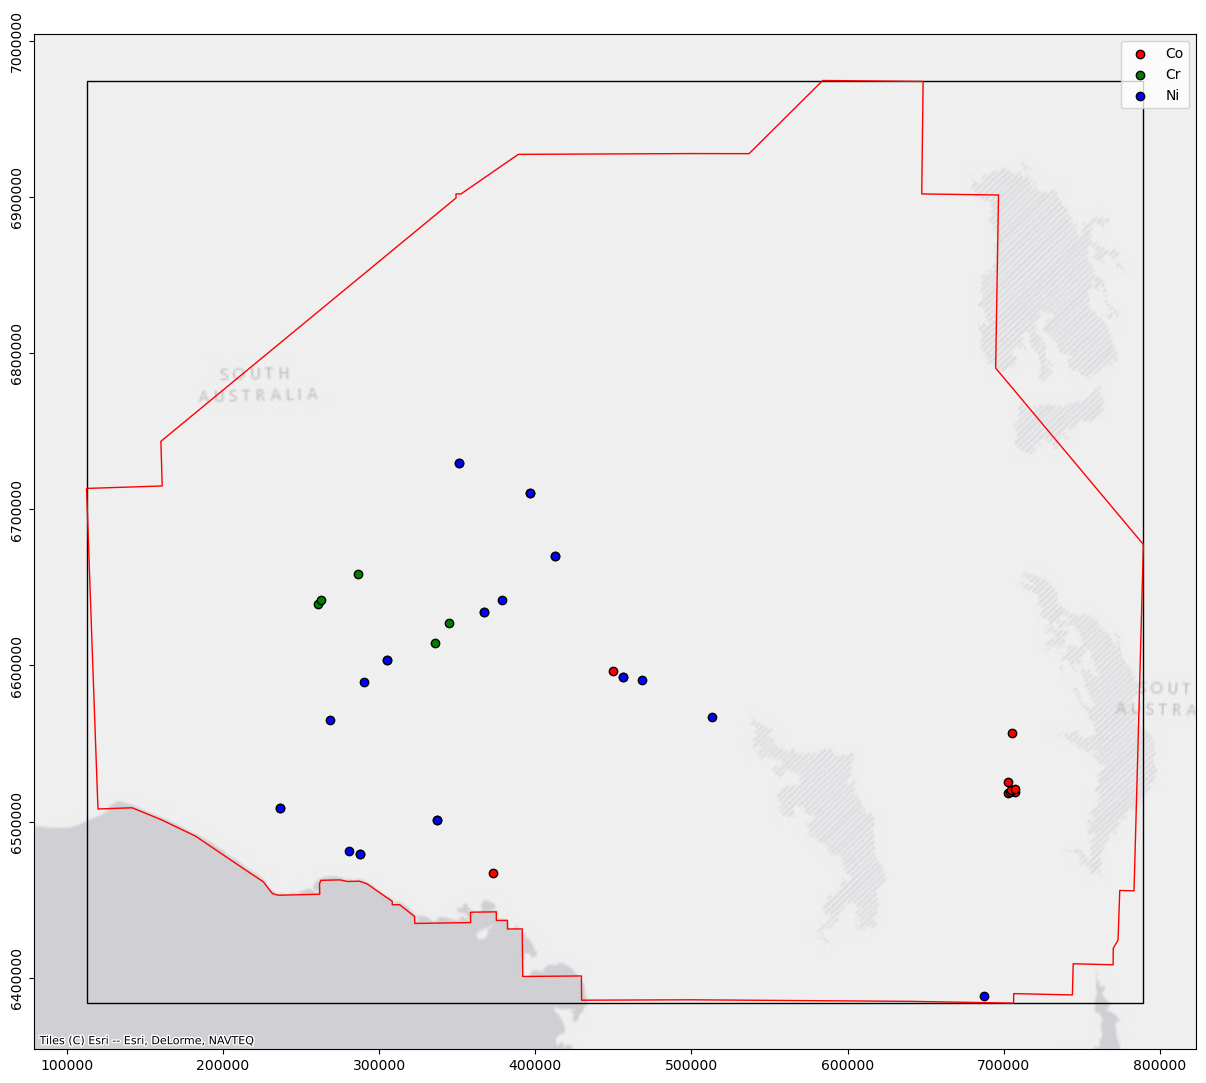

In [3]:
# read boundaries
gc_frame = gpd.read_file('./Datasets/Frames/GC_Frame_MGA53.shp')
gc_frame = gc_frame.to_crs('epsg:7853')
gc_polygon = gpd.read_file('./Datasets/Frames/GC_Polygon_MGA53.shp')
gc_polygon = gc_polygon.to_crs('epsg:7853')
bounds = gc_frame.bounds
extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

# mineral occurrences
mines_co = gpd.read_file('./Datasets/Mineral occurrences/cobalt.shp')
mines_co = mines_co.to_crs('epsg:7853')
mines_co = mines_co.clip(gc_polygon)
mines_cr = gpd.read_file('./Datasets/Mineral occurrences/chromium.shp')
mines_cr = mines_cr.to_crs('epsg:7853')
mines_cr = mines_cr.clip(gc_polygon)
mines_ni = gpd.read_file('./Datasets/Mineral occurrences/nickel.shp')
mines_ni = mines_ni.to_crs('epsg:7853')
mines_ni = mines_ni.clip(gc_polygon)

# target mineralization types
cox_class = ['Deposits related to mafic and ultramafic intrusions in stable environments',
             'Deposits related to mafic-ultramafic rocks in unstable areas']

# plot the mineral occurrences
fig, ax = plt.subplots(figsize=(15, 15))
mines_co.plot(ax=ax, edgecolor='black', color='red')
mines_cr.plot(ax=ax, edgecolor='black', color='green')
mines_ni.plot(ax=ax, edgecolor='black', color='blue')
gc_frame.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
gc_polygon.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
# Esri: WorldStreetMap, DeLorme, WorldTopoMap, WorldImagery, WorldTerrain, WorldShadedRelief, WorldPhysical, OceanBasemap,
# NatGeoWorldMap, WorldGrayCanvas
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.legend(['Co', 'Cr', 'Ni'])
plt.grid(False)
plt.show()

### Target Points

Number of samples: 73561


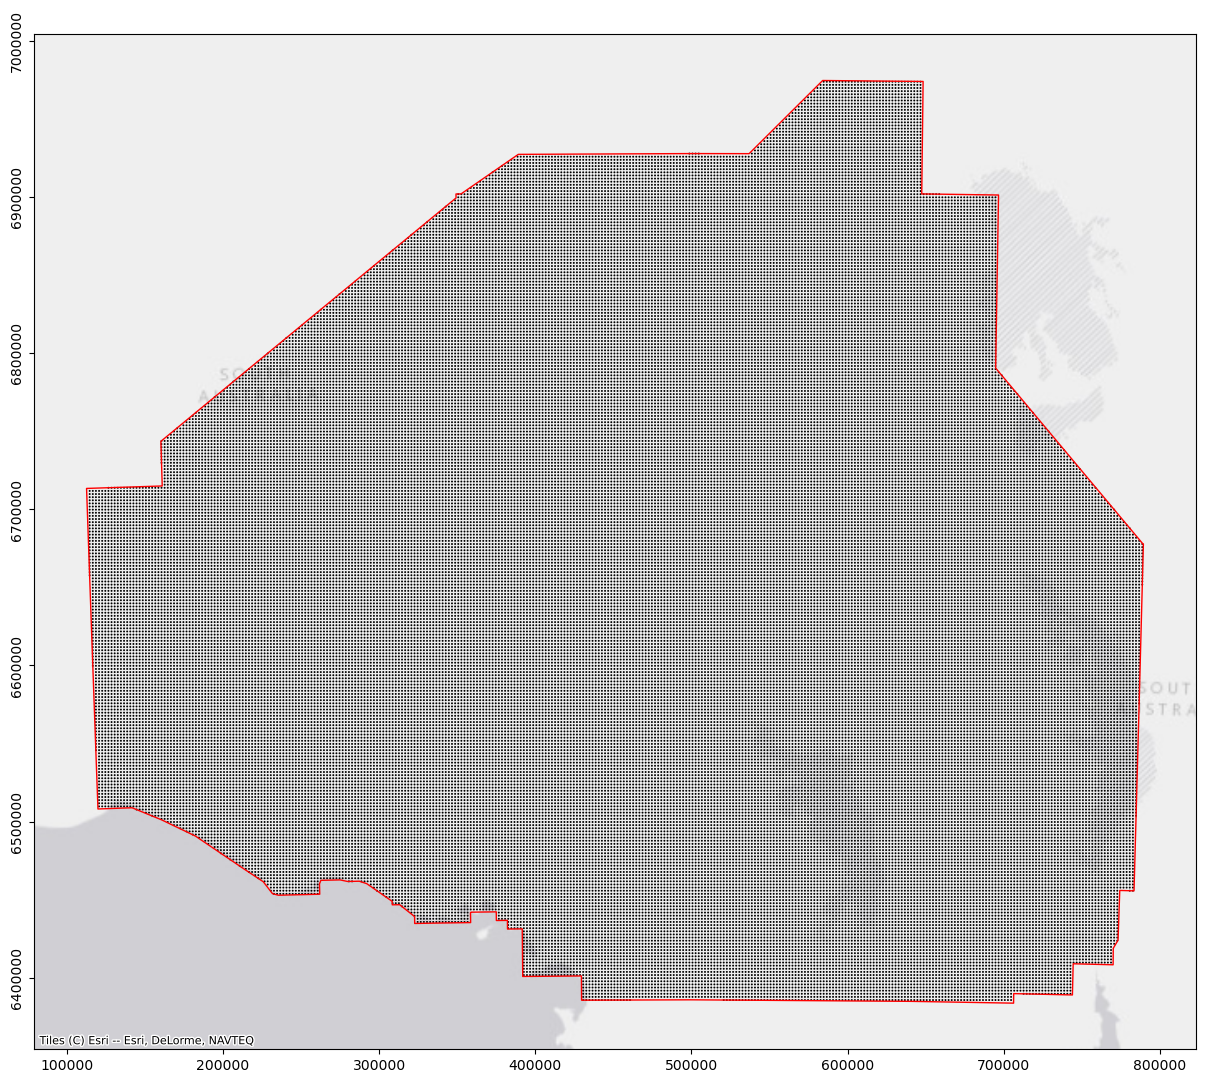

In [4]:
# set the sampling resolution in meter
dist_x, dist_y = (2000, 2000)
x = np.arange(extent[0], extent[1], dist_x)
y = np.arange(extent[2], extent[3], dist_y)
nx = len(x)
ny = len(y)
xs, ys = np.meshgrid(x, y)
xs_flat = xs.flatten()
ys_flat = ys.flatten()

sample_x = []
sample_y = []
sample_mask = []
for xx, yy in zip(xs_flat, ys_flat):
    p = Point((xx, yy))
    if p.within(gc_polygon.geometry[0]):
        sample_x.append(xx)
        sample_y.append(yy)
        sample_mask.append(True)
    else:
        sample_mask.append(False)

sample_coords = pd.DataFrame(sample_x, columns=['X'])
sample_coords['Y'] = sample_y
mask_x = np.array([xs_flat]).T
mask_y = np.array([ys_flat]).T
sample_mask = np.array([sample_mask]).T
mask_coords = np.hstack((mask_x, mask_y, sample_mask))

print('Number of samples:', len(sample_x))

mask_2d = np.reshape(sample_mask, (ny, nx))
mask_2d_ud = np.flipud(mask_2d)

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(sample_x, sample_y, color='black',  edgecolors='none', s=2)
gc_polygon.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.show()

### PCA

In [5]:
def plot_array_stretched(array, label):
    fig, ax = plt.subplots(figsize=(15, 15))
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    gc_polygon.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

def plot_array(array, label):
    fig, ax = plt.subplots(figsize=(15, 15))
    gc_polygon.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Spectral_r', extent=extent)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

geophy_features_file = './Geophysical Features_No Res01.csv'

if os.path.isfile(geophy_features_file):
    print('The geophysical features already exist.')
    geophy_features = pd.read_csv(geophy_features_file, index_col=False)
else:
    mag_features = pd.read_csv('./Magnetic Features.csv', index_col=False)
    grav_features = pd.read_csv('./Gravity Features.csv', index_col=False)
    geophy_features = pd.concat([mag_features, grav_features], axis=1).reset_index(drop=True)
    geophy_features.to_csv(geophy_features_file, index=False)
    print(f'The geophysical features have been saved to {geophy_features_file}.')

# pca
pca = PCA()
components = pca.fit_transform(geophy_features)
var_ratio = pca.explained_variance_ratio_
var_sum = 0

for i in range(len(var_ratio)):
    if var_sum >= 0.99:
        break
    else:
        var_sum += var_ratio[i]

selected_components = components[:, :i]
print('Number of input features:', geophy_features.shape[1])
print('Number of components:', selected_components.shape[1])

@interact(pc_num=list(range(1, selected_components.shape[1]+1)))
def show_map(pc_num):
    pc = selected_components[:, pc_num-1]
    pc_2d = np.reshape(pc, (ny, nx))
    pc_2d_ud = np.flipud(pc_2d)
    pc_2d_ud_copy = pc_2d_ud.copy()
    pc_2d_ud_copy[~mask_2d_ud] = float('nan')
    plot_array_stretched(pc_2d_ud_copy, 'PC')

The geophysical features already exist.
Number of input features: 224
Number of components: 3


interactive(children=(Dropdown(description='pc_num', options=(1, 2, 3), value=1), Output()), _dom_classes=('wi…

### Elbow Method

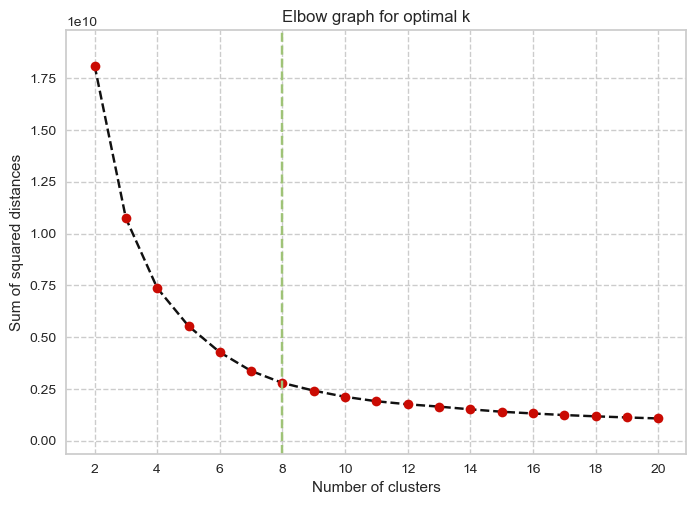

In [6]:
from yellowbrick.cluster import KElbowVisualizer

# two options for plotting the elbow graph
# option 1 without using the yellowbrick library
sum_squared_distance = []
range_n_clusters = range(2, 21)
for k in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=k, random_state=1)
    clusterer.fit(selected_components)
    sum_squared_distance.append(clusterer.inertia_)

range_ssd = max(sum_squared_distance) - min(sum_squared_distance)

plt.plot(range_n_clusters, sum_squared_distance, 'ko--', mfc='r')
plt.vlines(x=8, ymin=min(sum_squared_distance)-(0.1*range_ssd),
           ymax=max(sum_squared_distance)+(0.1*range_ssd), color='g', linestyles='dashed')
plt.xticks(range(2, 21, 2))
plt.ylim(min(sum_squared_distance)-(0.1*range_ssd), max(sum_squared_distance)+(0.1*range_ssd))
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow graph for optimal k')
plt.grid(linestyle='--')
plt.show()

# # option 2 using the yellowbrick library
# visualizer = KElbowVisualizer(cluster.KMeans(random_state=1), k=(2, 21), timings=True)
# # fit the data
# visualizer.fit(selected_components)
# # finalize and render figure
# visualizer.show()

# Clustering k-means

## Optimization of Hyperparameters

In [7]:
%%time
from sklearn import cluster
from sklearn.metrics import silhouette_score
import random

# Define hyperparameter ranges
n_init_range = range(1, 10, 2)  # From 1 to 10 with intervals of 2
max_iter_range = range(1, 1000, 100)  # From 1 to 1000 with intervals of 100
tolerance_range = np.arange(1, 10, 2)  # From 1 to 10 with intervals of 2

# Fixed hyperparameters
n_clusters = 8  # Number of clusters
init_method = 'k-means++'  # Method for initialization
random_state = 1  # Random state for reproducibility

# Select a random subset of parameter combinations
random_init = random.sample(list(n_init_range), 3)
random_max_iter = random.sample(list(max_iter_range), 3)
random_tolerance = random.sample(list(tolerance_range), 3)

# Initialize variables to store the best parameters and performance
best_score = -1
best_params = {}

# Loop over all parameter combinations
for n_init, max_iter, tolerance in zip(random_init, random_max_iter, random_tolerance):
    # k-means clustering using the components
    k_means = cluster.KMeans(n_clusters=n_clusters, init=init_method, n_init=n_init,
                             max_iter=max_iter, tol=tolerance, random_state=random_state)

    # Train the model
    pred = k_means.fit_predict(selected_components)

    # Compute silhouette score
    score = silhouette_score(selected_components, pred)
    
    # Update best parameters if the current silhouette score is higher
    if score > best_score:
        best_score = score
        best_params = {'n_init': n_init, 'max_iter': max_iter, 'tolerance': tolerance}

# Print the best parameters and performance
print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_score)

Best Parameters: {'n_init': 7, 'max_iter': 201, 'tolerance': 9}
Best Silhouette Score: 0.44357069447143005
CPU times: total: 10min 20s
Wall time: 6min 49s


In [ ]:
# Best Parameters: {'n_init': 7, 'max_iter': 201, 'tolerance': 9}
# Best Silhouette Score: 0.44357069447143005
# CPU times: total: 10min 20s
# Wall time: 6min 49s

## k-means clustering result

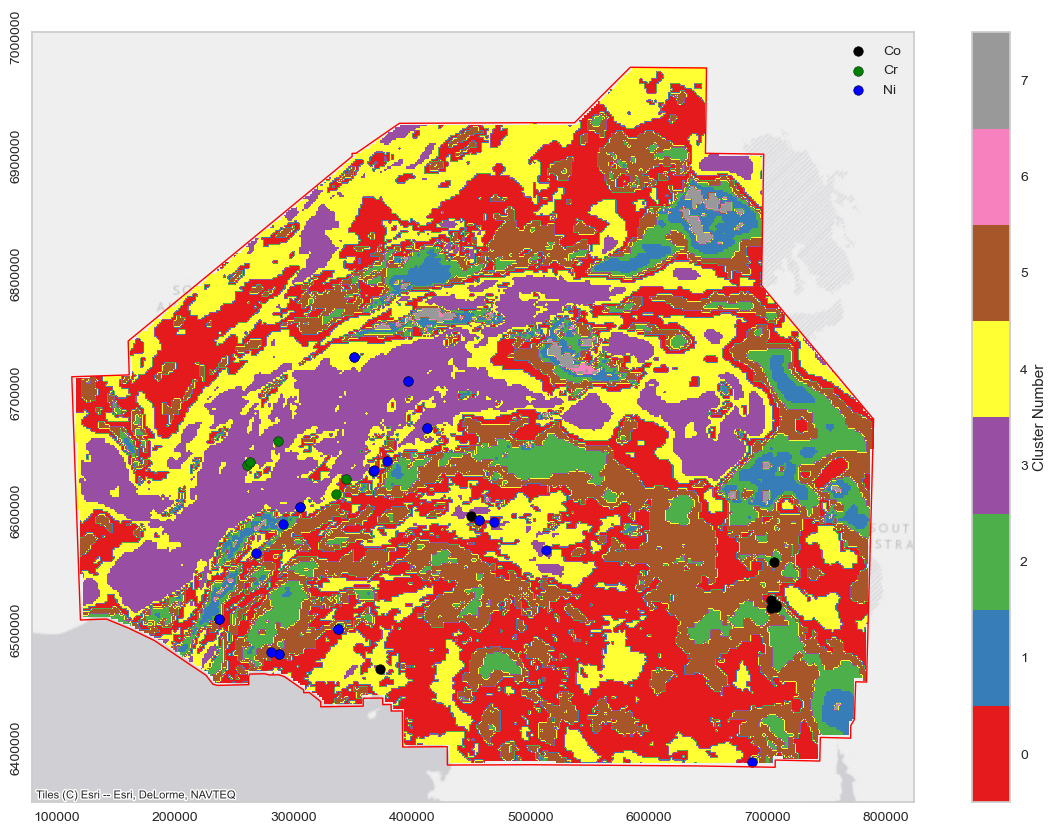

In [7]:
from sklearn import cluster
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import contextily as cx
from matplotlib import cm

# Fixed hyperparameters for KMeans with adjusted speed
n_clusters = 8  # Number of clusters
init_method = 'k-means++'  # Method for initialization
n_init = 7  # Number of times the k-means algorithm will be run with different centroid seeds (reduced from 10)
max_iter = 201  # Maximum number of iterations of the k-means algorithm for a single run (reduced from 300)
tolerance = 9  # Tolerance to declare convergence

# k-means clustering using the components generated in the previous cell
k_means = cluster.KMeans(n_clusters=n_clusters, init=init_method, n_init=n_init,
                         max_iter=max_iter, tol=tolerance, random_state=1)

# Train the model
pred = k_means.fit_predict(selected_components)

# Get cluster labels
labels = k_means.labels_

# Reshape labels
labels = labels.reshape((ny, nx))
labels = labels.astype('float')
labels = np.flipud(labels)
labels[~mask_2d_ud] = float('nan')

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
mines_co.plot(ax=ax, edgecolor='black', color='black')
mines_cr.plot(ax=ax, edgecolor='black', color='green')
mines_ni.plot(ax=ax, edgecolor='black', color='blue')
gc_polygon.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = cm.get_cmap('Set1', n_clusters)
plt.imshow(labels, cmap=cmap, extent=extent)
cbar = plt.colorbar(label='Cluster Number')
tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(n_clusters))
plt.legend(['Co', 'Cr', 'Ni'])
plt.grid(False)
plt.show()

In [8]:
# Get the unique values in som_labels as a list
unique_values_list = np.unique(labels).tolist()
print("Unique values in labels:", unique_values_list)
print("Number of unique values:", len(unique_values_list))

Unique values in labels: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]
Number of unique values: 9


In [9]:
# export an array to a GeoTIFF file
def save_tiff_output(array, index):
    dist_x = 2000
    dist_y = 2000
    geotransform = (extent[0], dist_x, 0, extent[3], 0, -dist_y)
    map_file = f'./Datasets/Output/{index}.tiff'
    driver = gdal.GetDriverByName('GTiff')
    nx = array.shape[1]
    ny = array.shape[0]
    dataset = driver.Create(map_file, nx, ny, 1, gdal.GDT_Float32)
    dataset.SetGeoTransform(geotransform)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(7853)
    dataset.SetProjection(srs.ExportToWkt())
    dataset.GetRasterBand(1).WriteArray(array)
    dataset.FlushCache()
    dataset = None

In [10]:
save_tiff_output(labels, 'Shallow_Mag_Grav_Kmeans')

# Clustering SOM

## Optimization of Hyperparameters

In [12]:
from minisom import MiniSom
from sklearn.metrics import silhouette_score
import numpy as np
import random

input_len = len(selected_components[0])  # Adjust this according to your input data dimensionality

# Define the parameter ranges
som_rows_range = list(range(5, 31, 5))
som_cols_range = list(range(5, 31, 5))
sigma_range = list(range(1, 10, 2))
learning_rate_range = list(np.arange(0, 1.1, 0.2))
iterations_range = list(range(100, 1001, 200))

# Randomly sample a subset of parameter combinations
parameter_combinations = list(zip(random.sample(som_rows_range, 3),
                                  random.sample(som_cols_range, 3),
                                  random.sample(sigma_range, 3),
                                  random.sample(learning_rate_range, 3),
                                  random.sample(iterations_range, 3)))

# Initialize variables to store the best parameters and performance
best_params = {}
best_performance = -1  # Initialize with a low value as silhouette score ranges from -1 to 1 (higher is better)

# Loop over all parameter combinations
for som_rows, som_cols, sigma, learning_rate, iterations in parameter_combinations:
    # Initialize the SOM
    som = MiniSom(som_rows, som_cols, input_len, sigma=sigma, learning_rate=learning_rate)
    
    # Train the SOM with current parameters
    som.train_batch(selected_components, iterations)
    
    # Assign each sample to its closest neuron
    pred = np.array([som.winner(x) for x in selected_components])
    
    # Flatten the SOM grid to get cluster labels
    som_labels = np.ravel_multi_index(pred.T, (som_rows, som_cols))
    
    # Compute silhouette score
    silhouette = silhouette_score(selected_components, som_labels)
    
    # Update best parameters if the current silhouette score is higher
    if silhouette > best_performance:
        best_params = {'som_rows': som_rows, 'som_cols': som_cols, 'sigma': sigma, 'learning_rate': learning_rate, 'iterations': iterations}
        best_performance = silhouette

# Print the best parameters and performance
print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_performance)

Best Parameters: {'som_rows': 15, 'som_cols': 5, 'sigma': 5, 'learning_rate': 0.6000000000000001, 'iterations': 700}
Best Silhouette Score: -0.050836839706485205


In [ ]:
# Best Parameters: {'som_rows': 15, 'som_cols': 5, 'sigma': 5, 'learning_rate': 0.6000000000000001, 'iterations': 700}
# Best Silhouette Score: -0.050836839706485205

## SOM Clustering result

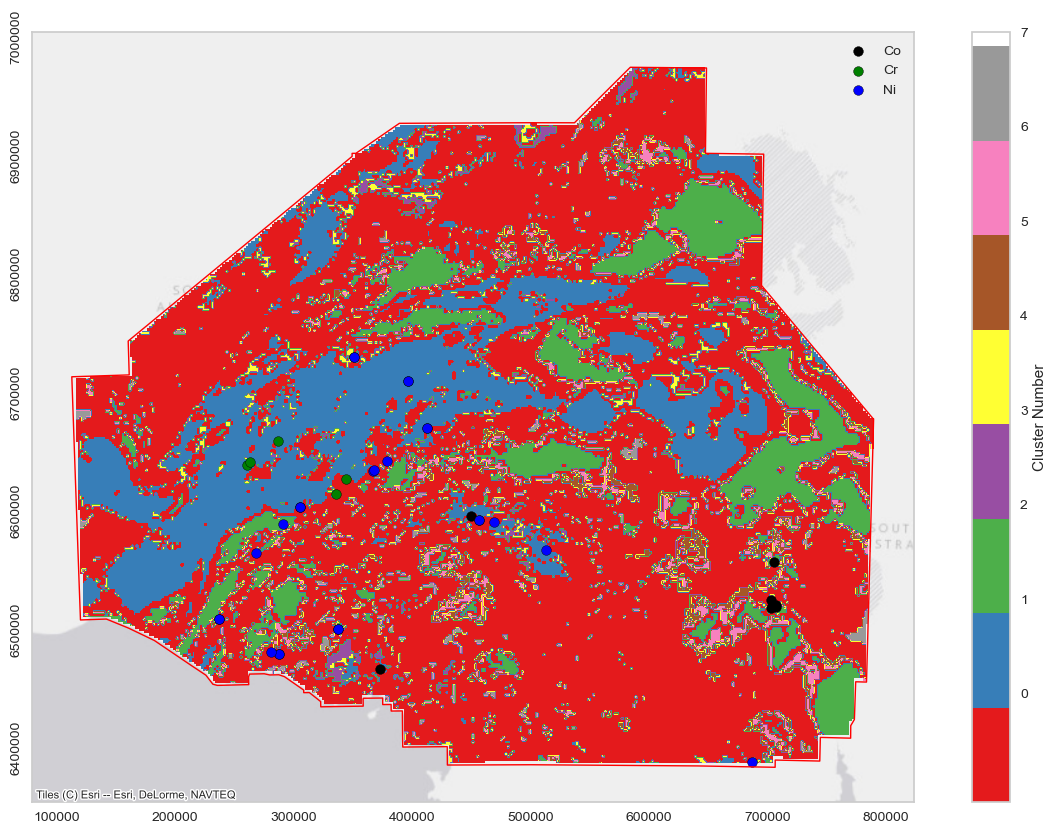

In [11]:
from minisom import MiniSom
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import contextily as cx
from matplotlib import cm
from collections import Counter  # Import Counter class

# Define SOM parameters
som_rows = 15  # Adjust the number of rows
som_cols = 5  # Adjust the number of columns
input_len = len(selected_components[0])  # Adjust this according to your input data dimensionality
sigma = 3  # Spread of the neighborhood function, adjust as needed
learning_rate = 0.6
num_clusters = 8  # Number of clusters

# Initialize the SOM
som = MiniSom(som_rows, som_cols, input_len, sigma=sigma, learning_rate=learning_rate)

# Train the SOM
som.train_batch(selected_components, 700)  # Adjust the number of iterations (2000 is an example)

# Assign each sample to its closest neuron
pred = np.array([som.winner(x) for x in selected_components])

# Flatten the SOM grid to get cluster labels
som_labels = np.ravel_multi_index(pred.T, (som_rows, som_cols))

# Find the top 8 most frequent cluster labels
top_labels = [label for label, count in Counter(som_labels).most_common(7)]

# Assign data points to the top 8 labels
som_labels = np.array([top_labels.index(label) if label in top_labels else -1 for label in som_labels])

# Reshape labels
som_labels = som_labels.reshape((ny, nx))
som_labels = som_labels.astype('float')
som_labels = np.flipud(som_labels)
som_labels[~mask_2d_ud] = float('nan')

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
mines_co.plot(ax=ax, edgecolor='black', color='black')
mines_cr.plot(ax=ax, edgecolor='black', color='green')
mines_ni.plot(ax=ax, edgecolor='black', color='blue')
gc_polygon.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = cm.get_cmap('Set1', num_clusters)  # Adjust the number of clusters here
plt.imshow(som_labels, cmap=cmap, extent=extent)
cbar = plt.colorbar(label='Cluster Number')
tick_locs = (np.arange(num_clusters) + 0.005) * (num_clusters - 1) / num_clusters
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(num_clusters))
plt.legend(['Co', 'Cr', 'Ni'])
plt.grid(False)
plt.show()

In [12]:
# Get the unique values in som_labels as a list
unique_values_list = np.unique(som_labels).tolist()
print("Unique values in som_labels:", unique_values_list)
print("Number of unique values:", len(unique_values_list))

Unique values in som_labels: [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]
Number of unique values: 9


In [13]:
save_tiff_output(som_labels, 'Shallow_Mag_Grav_SOM')